In [2]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np

import openeo

In [56]:
connection = openeo.connect(url="http://127.0.0.1:8081/").authenticate_oidc()

fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}}, 
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}},
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}}, 
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}}
    ]}
"""
)

s2cube = connection.load_collection(
    "sentinel-2-l2a",
    temporal_extent=["2020-06-01", "2020-08-01"],
    spatial_extent={"west": 5.05, "south": 51.21, "east": 5.09, "north": 51.24},
    bands=["B04_10m", "B08_10m"],
)
red = s2cube.band("B04_10m")
nir = s2cube.band("B08_10m")
ndvi = (nir - red) / (nir + red)

timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

timeseries.download("timeseries-basic.csv", format="csv")
pd.read_csv("timeseries-basic.csv", index_col=0).head()

Authenticated using refresh token.


,feature_index,value
date,,
2020-07-31T10:36:29.024Z,0,0.503734
2020-07-29T10:50:31.024Z,0,0.476434
2020-07-26T10:40:31.024Z,0,0.269690
2020-07-24T10:46:19.025Z,0,0.300321
2020-07-21T10:36:29.024Z,0,0.442549


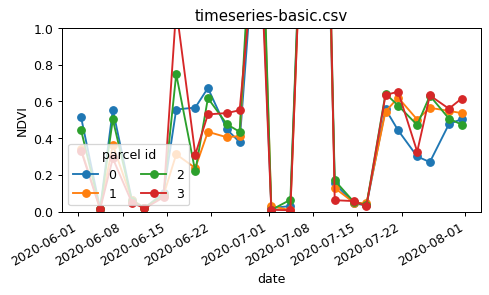

In [57]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["value"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

plot_timeseries("timeseries-basic.csv")